In [1]:
import camb
import numpy as np
import time
import matplotlib.pyplot as plt

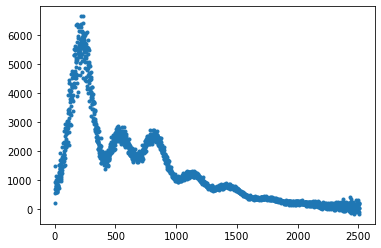

In [2]:
f = np.loadtxt('./COM_PowerSpect_CMB-TT-full_R3.01.txt')
multipole=f[:,0]
Sky_Variance=f[:,1]
low=f[:,2]
high=f[:,3]
plt.plot(multipole, Sky_Variance, '.')

3049
chisq is  15267.937968222595  for  2501  degrees of freedom.


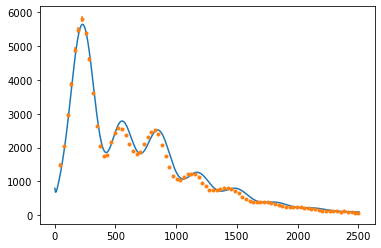

In [3]:
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]

plt.ion()

pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
#pars2 = np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])

#pars = pars2

print(len(get_spectrum(pars)))

planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()



In [8]:
x = Deriv(get_spectrum, [60,0.02,0.1,0.05,2.00e-9,1.0])
np.mean(x[:,0])

-3.560969200993241

In [9]:
def ndiff(fun, args, pos):
    x = args[pos]
    dx = 1e-5 * x
    args[pos] = x+dx
    fx1 = fun(args)
    args[pos] = x-dx
    fx2 = fun(args)
    deriv = (fx1 - fx2)/(2*dx)
    return deriv

def Deriv(fun, args):
    y = fun(args)
    derivs = np.zeros([len(y), len(args)])
    for i in range(len(args)):
        derivs[:, i] = ndiff(get_spectrum, args, i)
    return derivs

def update_lamda(lamda, success):
    if success: 
        lamda = lamda/1.5
        if lamda<0.5:
            lamda=0
    else : 
        if lamda==0:
            lamda=1
        else : 
            lamda=lamda*1.5**2
    return lamda
            
def fit_LM(fun, args, y, error, niter=50, chitol=0.01):
    lamda = 1
    model = fun(args)
    model = model[:len(y)]
    r = y-model
    chisq_old = np.sum((r/error)**2)
    print('Initial chisq value is ', chisq_old)
    for i in range(niter):
        #Get trial step
        deriv = Deriv(fun, args)
        model = model[:len(y)]
        deriv = deriv[:len(y)]
        r = y-model
        lhs = deriv.T@deriv
        lhs = lhs + lamda*np.diag(np.diag(lhs))
        rhs = deriv.T@r
        dm = np.linalg.inv(lhs)@rhs
        args_trial = args+dm
        #Re-calculate the model to get chi-squared
        model = fun(args_trial)
        model = model[:len(y)]
        r = y-model
        chisq_new = np.sum((r/error)**2)
        if chisq_new<chisq_old:
            lamda = update_lamda(lamda, True)
            args = args_trial
            print('accepting step with new chisq ',chisq_new, 'and old chisq ',chisq_old)
            chisq_old = chisq_new
        elif np.abs(chisq_new-chisq_old)<chitol:
            break
        else :
            lamda = update_lamda(lamda, False)
            print('rejecting step with new chisq ',chisq_new, 'and old chisq ',chisq_old)
        print('On iteration', i, 'chisq is ', chisq_new, 'with step ', dm, 'and lamda ', lamda)
    last_deriv = Deriv(fun, args)
    last_lhs = last_deriv.T@last_deriv
    Cov = np.linalg.inv(last_lhs)
    errors = np.sqrt(np.diag(Cov))
    return args, errors, last_lhs

In [ ]:
params = np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
start_y = planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])
Bestfit_args, Bestfit_err, Cur = fit_LM(get_spectrum, params, start_y, errs)
Cur = np.linalg.inv(Cur)

Initial chisq value is  15267.937968222595
accepting step with new chisq  5219.453288697082 and old chisq  15267.937968222595
On iteration 0 chisq is  5219.453288697082 with step  [ 4.96599818e+00  1.55679536e-04  3.07418180e-03  2.14942646e-03
 -8.13450976e-12 -1.71315665e-02] and lamda  0.6666666666666666
accepting step with new chisq  3212.1743111837213 and old chisq  5219.453288697082
On iteration 1 chisq is  3212.1743111837213 with step  [ 3.38069375e+00  5.32098335e-04  1.92043872e-03 -4.26811659e-04
  1.71921232e-12 -9.90353287e-03] and lamda  0
rejecting step with new chisq  6500.447764976598 and old chisq  3212.1743111837213
On iteration 2 chisq is  6500.447764976598 with step  [-1.58393169e+00  1.47404616e-03  1.41363699e-02 -9.07407714e-02
 -2.72048015e-10 -1.35381297e-02] and lamda  1
rejecting step with new chisq  5013.7774590440595 and old chisq  3212.1743111837213
On iteration 3 chisq is  5013.7774590440595 with step  [ 1.58902813e-01  2.24659632e-04 -2.57224702e-03 -1.0

In [ ]:
line = ['The best-fit parameters are: ','H0: '+str(Bestfit_args[0])+' +/- '+str(Bestfit_err[0]),
        'ombh2: '+str(Bestfit_args[1])+' +/- '+str(Bestfit_err[1]), 
        'omch2: '+str(Bestfit_args[2])+' +/- '+str(Bestfit_err[2]),
        'tau: '+str(Bestfit_args[3])+' +/- '+str(Bestfit_err[3]),
        'As: '+str(Bestfit_args[4])+' +/- '+str(Bestfit_err[4]),
        'ns: '+str(Bestfit_args[5])+' +/- '+str(Bestfit_err[5])]
L = open('./planck_fit_params.txt', 'w')
for elem in line: 
    L.write(elem+'\n')
L.close()

In [ ]:
#pars2 = np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
print(Bestfit_args, Cur)
print(Cur.shape)
print(Bestfit_err)
print(Cur.shape)
Cur

In [ ]:
def Mean_Dark_Energy(H0, ombh2, omch2, H0_err, ombh2_err, omch2_err):
    h = H0 / 100
    h_err = H0_err / 10
    omb = ombh2 / h**2
    omb_err = (omb*h_err)/(h**3)
    omc = omch2 / h**2
    omc_err = (omc*h_err)/(h**3)
    omD = 1 - omb - omc
    omD_err = np.sqrt(omb_err**2 + omc_err**2)
    return omD, omD_err

errs=0.5*(planck[:,2]+planck[:,3])

def get_spectrum_chisq(args, y, errors=errs):
    model = get_spectrum(args)
    model = model[:len(y)]
    r = y - model
    chisq = np.sum((r/errors)**2)
    return chisq

def mcmc(pars,y,fun,curv,nstep):
    chi_cur=fun(pars,y)
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    L = np.linalg.cholesky(curv)
    curv = np.dot(L,np.random.randn(len(pars)))
    for i in range(nstep):
        trial_pars=pars + curv
        #trial_pars[3] = np.random.normal(0.0540, 0.0074)
        trial_chisq=fun(trial_pars,y)
        delta_chisq=trial_chisq-chi_cur
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob
        if accept:
            pars=trial_pars
            chi_cur=trial_chisq
            chain[i,:]=pars
            chivec[i]=chi_cur
    return chain,chivec

pars = np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
npar=len(pars)
y = planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])

chain,chisq=mcmc(pars,y,get_spectrum_chisq,Cur,nstep=2000)
print('param chain is: ',chain, 'chi squared chain is: ',chisq)

In [15]:
error = np.std(chain, axis=0)
bestfit_MCMC_param = chain[len(chain)-1]
omd, omd_err = Mean_Dark_Energy(bestfit_MCMC_param[0], bestfit_MCMC_param[1], bestfit_MCMC_param[2], error[0], error[1], error[2])
print('The mean value of dark energy is ', omd, ' +/- ',omd_err)

The mean value of dark energy is  0.6744904382911785  +/-  0.014188959637488566


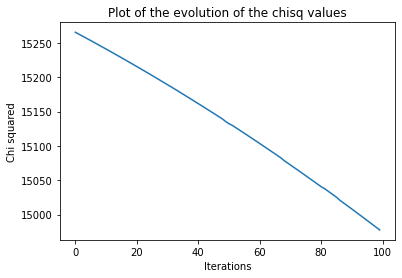

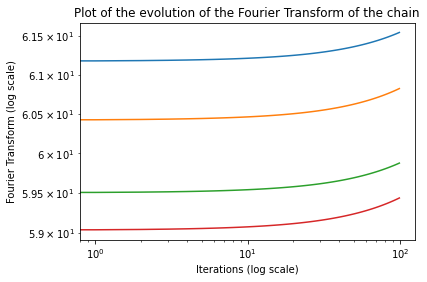

In [32]:
plt.plot(chisq)
plt.xlabel('Iterations')
plt.ylabel('Chi squared')
plt.title('Plot of the evolution of the chisq values')
plt.show()
chainft = np.fft.rfft(chain)
plt.loglog(np.abs(chainft))
plt.xlabel('Iterations (log scale)')
plt.ylabel('Fourier Transform (log scale)')
plt.title('Plot of the evolution of the Fourier Transform of the chain')
plt.show()

In [27]:
line = np.zeros([len(chisq), npar+1])
line[:, 0] = chisq
line[:, 1] = chain[:, 0]
line[:, 2] = chain[:, 1]
line[:, 3] = chain[:, 2]
line[:, 4] = chain[:, 3]
line[:, 5] = chain[:, 4]
line[:, 6] = chain[:, 5]

L = open('./planck_chain.txt', 'w')
for elem in line: 
    L.write(str(elem)+'\n')
L.close()

In [ ]:
def mcmc_withprior(pars,y,fun,curv,nstep):
    chi_cur=fun(pars,y)
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    L = np.linalg.cholesky(curv)
    curv = np.dot(L,np.random.randn(len(pars)))
    for i in range(nstep):
        trial_pars=pars + curv
        trial_pars[3] = np.random.normal(0.0540, 0.0074)
        trial_chisq=fun(trial_pars,y)
        delta_chisq=trial_chisq-chi_cur
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob
        if accept:
            pars=trial_pars
            chi_cur=trial_chisq
            chain[i,:]=pars
            chivec[i]=chi_cur
    return chain,chivec

pars = np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
npar=len(pars)
y = planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])

newchain,newchisq=mcmc_withprior(pars,y,get_spectrum_chisq,Cur,nstep=100)
print('param chain is: ',chain, 'chi squared chain is: ',chisq)

In [ ]:
new_error = np.std(newchain, axis=0)
new_bestfit_MCMC_param = newchain[len(newchain)-1]
new_omd, new_omd_err = Mean_Dark_Energy(new_bestfit_MCMC_param[0], new_bestfit_MCMC_param[1], new_bestfit_MCMC_param[2], new_error[0], new_error[1], new_error[2])
print(omd, omd_err)

In [ ]:
line = np.zeros([len(y), npar+1])
line[:, 0] = newchisq
line[:, 1] = newchain[:, 0]
line[:, 2] = newchain[:, 1]
line[:, 3] = newchain[:, 2]
line[:, 4] = newchain[:, 3]
line[:, 5] = newchain[:, 4]
line[:, 6] = newchain[:, 5]

L = open('./planck_chain.txt', 'w')
for elem in line: 
    L.write(str(elem)+'\n')
L.close()